# Práctica NLP
Hecha por Rubén Cerezo Cuesta
En esta práctica, vamos a hacer dos modelos de NLP a partir de un dataset de Amazon formado por reseñas de videojuegos. Con esto, esperamos conseguir un análisis de sentimiento. Tras entrenar estos modelos, podremos conseguir una herramienta que catalogue reviews en función de cómo de positivas son. 
Este trabajo está dividido en 4 fases:
- Exploración de datos
- Preprocesamiento de datos
- **División Train/Test y entrenamiento**
- Métricas y conclusiones
En este caso, el corpus elegido, de Amazon, incluye reviews de videojuegos, simplemente por ser un tema que conozco y que he pensado que podría resultar fácil a la hora de reconocer el producto con el que trabajo. 

#  Modelo 1: Machine Learning

En esta parte de nuestra práctica, realizamos el pipeline completo de entrenamiento de un modelo de Machine Learning para clasificar reviews en función de su puntuación. El flujo seguido es el siguiente:

División del dataset en un conjunto de entrenamiento (75%) y otro de prueba (25%), asegurando aleatoriedad y reproducibilidad mediante una semilla fija.

Creación y ajuste de un vectorizador TF-IDF utilizando únicamente los datos de entrenamiento. Este vectorizador convierte el texto de las reviews en representaciones numéricas, incluyendo uni-, bi- y trigramas, y filtrando términos demasiado frecuentes o demasiado raros.

Transformación del texto de los conjuntos de entrenamiento y prueba mediante el vectorizador ajustado.

Entrenamiento de varios modelos de Regresión Logística probando diferentes valores del hiperparámetro C, que controla el nivel de regularización. Para cada modelo se calcula el accuracy tanto en train como en test.

Selección del mejor modelo basándonos en el mayor accuracy obtenido sobre el conjunto de prueba.

Entrenamiento final del modelo óptimo utilizando el mejor valor de C encontrado.

Guardado del modelo entrenado en disco mediante joblib, permitiendo reutilizarlo posteriormente sin necesidad de volver a entrenarlo.

In [4]:
# Como parte de las buenas prácticas de Machine Learning, realizamos de nuevo todo el proceso en una sóla celda, eliminando las partes del código que hemos usado para comprobar que lo estábamos haciendo bien.
#  Esto nos da más control sobre el código,
#Cargamos el archivo .csv 
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

path = r'reviews_Video_Games_5_balanced_preprocessed_0-1.csv'

df = pd.read_csv(path)
df.head()
#Separamos en train y test con una muestra de train del 75% y una muestra de test del 25% 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['overall'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)


#  pipeline y búsqueda de hiperparámetros
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(strip_accents='ascii')),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__min_df': [1, 3, 5],
    'tfidf__max_df': [0.9, 0.95, 0.98],
    'tfidf__max_features': [5000, 10000, 20000],
    'clf__C': [0.1, 1, 3, 10],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='accuracy',  
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Mejores parámetros encontrados por GridSearch:")
print(grid.best_params_)
print("Mejor score CV:", grid.best_score_)


vectorizer = grid.best_estimator_.named_steps['tfidf']

# Transformamos los datos de train y test
X_train_ = vectorizer.transform(X_train)
X_test_ = vectorizer.transform(X_test)

# Entrenamiento y evaluación del modelo de Regresión Logística con diferentes valores de C
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

# Guardamos el mejor modelo entrenado en una carpeta especifica para este modelo 
best_c = c_params[test_acc.index(max(test_acc))]
best_lr = LogisticRegression(C=best_c, solver='lbfgs', max_iter=2000, n_jobs=-1)
best_lr.fit(X_train_, y_train)

model_dir = r"modelos\Logistic_regression_tf_idf0-1"

# -------------------------------
# Cambio mínimo necesario:
# crear la carpeta si no existe
# -------------------------------
import os
os.makedirs(model_dir, exist_ok=True)

# Guardar modelo
joblib.dump(best_lr, fr"{model_dir}\model.pkl")
# Guardar vectorizador
joblib.dump(vectorizer, fr"{model_dir}\vectorizer.pkl")

# Guardar X_test y y_test
joblib.dump((X_test.reset_index(drop=True), y_test.reset_index(drop=True)), fr"{model_dir}\test_data.pkl")


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Mejores parámetros encontrados por GridSearch:
{'clf__C': 3, 'tfidf__max_df': 0.9, 'tfidf__max_features': 5000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 3)}
Mejor score CV: 0.8123333333333332
Accuracy for C=0.01: 0.751
Accuracy for C=0.05: 0.764
Accuracy for C=0.25: 0.784
Accuracy for C=0.5: 0.793
Accuracy for C=1: 0.803
Accuracy for C=10: 0.803
Accuracy for C=100: 0.788
Accuracy for C=1000: 0.786
Accuracy for C=10000: 0.784


['modelos\\Logistic_regression_tf_idf0-1\\test_data.pkl']

# Modelo nº 2: Machine Learning (Bag of Words + Regresión Logística)

En esta parte de la práctica realizamos el proceso completo de preparación, vectorización y entrenamiento de un modelo de Machine Learning para clasificar reviews según su puntuación. El flujo seguido es el siguiente
- Carga del dataset
Se carga el archivo CSV preprocesado que contiene las reseñas y sus puntuaciones. También se visualizan las primeras filas para comprobar que los datos se han leído correctamente.

- Creación y ajuste del vectorizador Bag of Words (CountVectorizer)
Se construye un vectorizador basado en el modelo Bag of Words, que transforma cada review en una matriz dispersa donde cada columna representa una palabra del vocabulario y cada fila corresponde a un documento.
Se ajusta el vectorizador a todas las reviews.
Se extraen las palabras del vocabulario usando get_feature_names_out().
Opcionalmente, se convierte la matriz dispersa en un DataFrame para visualizar la representación numérica de los textos.

- División del dataset en entrenamiento y prueba
Se divide la matriz generada (X) y las etiquetas (y) en:
75% → entrenamiento
25% → prueba
Esta división se realiza de forma aleatoria pero reproducible, gracias a la semilla random_state=42.

- Entrenamiento del modelo de Regresión Logística
Se entrena un modelo de Regresión Logística utilizando las representaciones Bag of Words del conjunto de entrenamiento.
Se ajusta el modelo con max_iter=500 para asegurar la convergencia.
El modelo aprende a asociar patrones de palabras con las puntuaciones de las reviews.

- Guardado del modelo entrenado
Una vez entrenado, el modelo se guarda en un archivo .pkl mediante joblib.
Esto permite reutilizarlo posteriormente para realizar predicciones sin necesidad de volver a entrenarlo, ahorrando tiempo y recursos.

In [5]:
# Código completo siguiendo buenas prácticas de ML
# Cargamos el archivo .csv: 
import pandas as pd
import joblib
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import uniform, randint#  Parámetros / rutas 


csv_path = r'reviews_Video_Games_5_balanced_preprocessed_0-1.csv'


#  Cargar datos 
df = pd.read_csv(csv_path)
df['reviewText'] = df['reviewText'].astype(str)  # asegurar strings
X_text = df['reviewText']
y = df['overall']

#  Train/test split ANTES de cualquier 'fit' del vectorizador 
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=y  # mantiene proporción de clases en ambos sets
)
# Definir un pipeline con CountVectorizer + LogisticRegression
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),             # default params, se optimizarán
    ('clf', LogisticRegression(solver="saga", max_iter=2000, n_jobs=-1))
])

# Espacio de búsqueda (RandomizedSearchCV para velocidad)
param_distributions = {
    'vectorizer__ngram_range': [(1,1), (1,2)],          # (1,3) suele ser caro; añadir si tienes recursos
    'vectorizer__min_df': [1, 2, 3, 5],
    'vectorizer__max_df': [0.7, 0.85, 0.9, 0.95],
    'vectorizer__max_features': [5000, 10000, 20000, None],
    'vectorizer__binary': [False, True],
    'clf__penalty': ['l2', 'elasticnet'],
    'clf__C': uniform(0.01, 10),                        # muestreo continuo para C entre 0.01 y 10
    'clf__l1_ratio': uniform(0, 1)                      # usado solo si penalty='elasticnet'
}

# Configurar RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=40,              # número de combinaciones a probar (ajusta según tiempo disponible)
    scoring='accuracy',     # puedes cambiar a 'f1_macro' si prefieres equilibrio entre clases
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Ajustar el pipeline (fit con X_train solamente) 
search.fit(X_train_text, y_train)
print("Mejores parámetros encontrados:")
print(search.best_params_)
print("Mejor score CV:", search.best_score_)

#  Evaluación sobre el set de test usando el mejor estimador 
best_pipeline = search.best_estimator_
y_pred = best_pipeline.predict(X_test_text)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

model_dir = r'modelos\Logistic_regression_bag_of_words0-1'
#  Guardar artefactos (modelo + vectorizador + test raw)
joblib.dump(best_pipeline.named_steps["clf"], os.path.join(model_dir, "model.pkl"))
joblib.dump(best_pipeline.named_steps["vectorizer"], os.path.join(model_dir, "vectorizer.pkl"))
# Guardar test raw para luego evaluar
joblib.dump((X_test_text.reset_index(drop=True), y_test.reset_index(drop=True)),
    os.path.join(model_dir, "test_data.pkl"))

Fitting 3 folds for each of 40 candidates, totalling 120 fits


c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Mejores parámetros encontrados:
{'clf__C': 1.205942459383017, 'clf__l1_ratio': 0.713244787222995, 'clf__penalty': 'l2', 'vectorizer__binary': False, 'vectorizer__max_df': 0.85, 'vectorizer__max_features': 20000, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2)}
Mejor score CV: 0.791
Accuracy: 0.794
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       500
           1       0.80      0.79      0.79       500

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000

Matriz de confusión:
[[398 102]
 [104 396]]


['modelos\\Logistic_regression_bag_of_words0-1\\test_data.pkl']

Entre nuestros dos modelos, ahora mismo el que nos da un 

# DistilBERT + Logistic Regression

En este caso, vamos a implementar un modelo distilBERT con pesos ya entrenados de serie para después, usando un modelo de regresión logística, entrenar un modelo útil que nos analice el sentimiento de nuestras reseñas 

In [6]:
# Como parte de las buenas prácticas, vamos a incluir todo el proceso en una sola celda
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
import pandas as pd
#En este caso, dado que Bert incluye su propio Tokenizador, vamos a cargar el dataset sin limpiar
path = r'reviews_Video_Games_5_balanced_preprocessed_0-1.csv'

df = pd.read_csv(path)
df.head()
# Eliminamos todas la columnas que no nos interesan (todas salvo 'reviewText' y 'overall')
df = df[['reviewText', 'overall']]
df.head()
# Importamos el modelo DistilBERT y su tokenizador
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')


# Los cargamos en la memoria del notebook 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# Importamos el modelo DistilBERT y su tokenizador
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')


# Los cargamos en la memoria del notebook 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
# inicializamos el tokenizador y el modelo
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Tokenizar toda la columna EN BLOQUE pero pidiendo tensores PyTorch.

encodings = tokenizer(
    df["reviewText"].tolist(),
    padding=True,          
    truncation=True,       
    max_length=512,
    return_tensors="pt"    
)
# Esto devuelve tensores ya paddeados al max del batch (sequence length <= 512
#
input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]

# DataLoader para procesar por lotes y evitar OOM
batch_size = 16  
dataset = TensorDataset(input_ids, attention_mask)
loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)  # pin_memory útil si hay GPU

# Pasar por el modelo por lotes (mover cada batch al dispositivo)
all_embeddings = []
with torch.no_grad():
    for b_input_ids, b_att_mask in loader:
        b_input_ids = b_input_ids.to(device, non_blocking=True)
        b_att_mask = b_att_mask.to(device, non_blocking=True)

        outputs = model(b_input_ids, attention_mask=b_att_mask)
        last_hidden = outputs.last_hidden_state  # (bs, seq_len, hidden_dim)
                # mean pooling considerando attention_mask
        mask = b_att_mask.unsqueeze(-1)
        summed = (last_hidden * mask).sum(1)
        counts = mask.sum(1).clamp(min=1)
        pooled = (summed / counts).cpu()  # mover a CPU para concatenar sin usar VRAM

        all_embeddings.append(pooled)

embeddings = torch.cat(all_embeddings, dim=0)  # (n_samples, hidden_dim)
print(embeddings.shape)

features = embeddings.numpy()
labels = df['overall'].values
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

from sklearn.model_selection import GridSearchCV

parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)
# 
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

import os
import json
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# --------------------------
# 1. Ruta de guardado
# --------------------------
SAVE_DIR = r"modelos\DistilBERT_lr_0-1"
os.makedirs(SAVE_DIR, exist_ok=True)

# --------------------------
# 2. Guardar tokenizer
# --------------------------
tokenizer.save_pretrained(os.path.join(SAVE_DIR, "tokenizer"))

# --------------------------
# 3. Guardar DistilBERT (congelado)
# --------------------------
model.save_pretrained(os.path.join(SAVE_DIR, "distilbert"))

# --------------------------
# 4. Guardar Logistic Regression
# --------------------------
joblib.dump(lr_clf, os.path.join(SAVE_DIR, "logreg_model.joblib"))

# --------------------------
# 5. Guardar configuración del modelo
# --------------------------
config = {
    "embedding_model": "distilbert-base-uncased",
    "pooling": "mean",
    "max_length": 512,
    "batch_size": 16,
    "classifier": "LogisticRegression",
    "classifier_params": lr_clf.get_params(),
}

with open(os.path.join(SAVE_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

# --------------------------
# 6. Guardar los splits
# --------------------------
splits = {
    "train_idx": train_features.shape[0],  # simplificado
    "test_idx": test_features.shape[0]
}
with open(os.path.join(SAVE_DIR, "splits.json"), "w") as f:
    json.dump(splits, f, indent=4)

# --------------------------
# 7. Predicciones en test
# --------------------------
y_true = test_labels
y_pred = lr_clf.predict(test_features)

df_pred = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred
})

df_pred.to_csv(os.path.join(SAVE_DIR, "test_predictions.csv"), index=False)

# --------------------------
# 8. Guardar classification report
# --------------------------
report = classification_report(y_true, y_pred, output_dict=True)
with open(os.path.join(SAVE_DIR, "classification_report.json"), "w") as f:
    json.dump(report, f, indent=4)

# --------------------------
# 9. Guardar matriz de confusión
# --------------------------
cm = confusion_matrix(y_true, y_pred)
np.savetxt(os.path.join(SAVE_DIR, "confusion_matrix.csv"), cm, delimiter=",", fmt="%d")

print("✔️ Artefactos guardados correctamente en:", SAVE_DIR)

c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([4000, 768])


c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\rammu\Documents\projects\NLP_04\práctica\NLP\.venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
 

best parameters:  {'C': 5.263252631578947}
best scrores:  0.7613333333333333
Dummy classifier score: 0.505 (+/- 0.00)
✔️ Artefactos guardados correctamente en: modelos\DistilBERT_lr_0-1


MÉTRICAS DE DESEMPEÑO - MODELO DistilBERT + LOGISTIC REGRESSION

✔️ MÉTRICAS GLOBALES:
   • Accuracy:  0.7910
   • Precision: 0.7910
   • Recall:    0.7910
   • F1-Score:  0.7910

✔️ MÉTRICAS POR CLASE:
   Clase 0:
      - Precision: 0.7984
      - Recall:    0.7938
      - F1-Score:  0.7961
   Clase 1:
      - Precision: 0.7832
      - Recall:    0.7881
      - F1-Score:  0.7856

✔️ REPORTE DE CLASIFICACIÓN DETALLADO:
              precision    recall  f1-score   support

     Clase 0       0.80      0.79      0.80       514
     Clase 1       0.78      0.79      0.79       486

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000


✔️ MATRIZ DE CONFUSIÓN:
[[408 106]
 [103 383]]


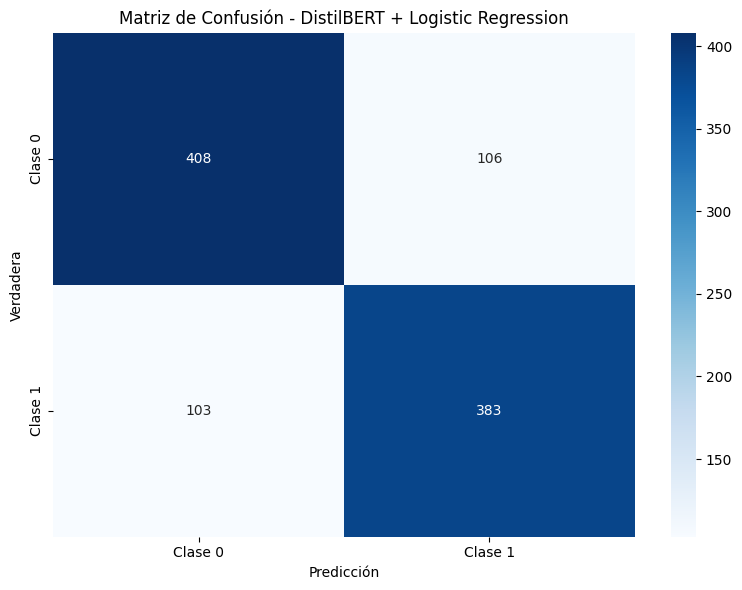


✔️ RESUMEN EN TABLA:
  Métrica    Valor
 Accuracy 0.791000
Precision 0.791046
   Recall 0.791000
 F1-Score 0.791016

✔️ Conjunto de prueba: 1000 muestras
✔️ Aciertos: 791 / 1000
✔️ Errores: 209 / 1000


In [7]:
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                             roc_auc_score, confusion_matrix, classification_report, 
                             roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# Calcular Métricas Principales
# --------------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Métricas adicionales por clase
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

print("=" * 60)
print("MÉTRICAS DE DESEMPEÑO - MODELO DistilBERT + LOGISTIC REGRESSION")
print("=" * 60)
print(f"\n✔️ MÉTRICAS GLOBALES:")
print(f"   • Accuracy:  {accuracy:.4f}")
print(f"   • Precision: {precision:.4f}")
print(f"   • Recall:    {recall:.4f}")
print(f"   • F1-Score:  {f1:.4f}")

print(f"\n✔️ MÉTRICAS POR CLASE:")
unique_labels = sorted(set(y_true))
for i, label in enumerate(unique_labels):
    print(f"   Clase {label}:")
    print(f"      - Precision: {precision_per_class[i]:.4f}")
    print(f"      - Recall:    {recall_per_class[i]:.4f}")
    print(f"      - F1-Score:  {f1_per_class[i]:.4f}")

print(f"\n✔️ REPORTE DE CLASIFICACIÓN DETALLADO:")
print(classification_report(y_true, y_pred, target_names=[f'Clase {i}' for i in unique_labels]))

# --------------------------
# Matriz de Confusión
# --------------------------
print(f"\n✔️ MATRIZ DE CONFUSIÓN:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Clase {i}' for i in unique_labels],
            yticklabels=[f'Clase {i}' for i in unique_labels])
plt.title('Matriz de Confusión - DistilBERT + Logistic Regression')
plt.ylabel('Verdadera')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()

# --------------------------
# Resumen en Tabla
# --------------------------
print(f"\n✔️ RESUMEN EN TABLA:")
metrics_summary = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Valor': [accuracy, precision, recall, f1]
})
print(metrics_summary.to_string(index=False))

print(f"\n✔️ Conjunto de prueba: {len(y_true)} muestras")
print(f"✔️ Aciertos: {(y_true == y_pred).sum()} / {len(y_true)}")
print(f"✔️ Errores: {(y_true != y_pred).sum()} / {len(y_true)}")